In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from models.cmpnts import InfoDiscriminator1D, BezierGenerator
from models.gans import BezierEGAN, BezierSEGAN
from train_e import read_configs, assemble_new_gan
from utils.dataloader import NoiseGenerator

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_dir = '../saves/sinkhorn'
checkpoint = 'modified499.tar'
data_fname = '../data/test.npy'
dis_cfg, gen_cfg, egan_cfg, cz = read_configs('modified')

In [4]:
egan = assemble_new_gan(dis_cfg, gen_cfg, egan_cfg, device=device)
egan.load(os.path.join(save_dir, checkpoint), train_mode=False)

test_data = torch.tensor(np.load(data_fname).transpose((0, 2, 1)), dtype=torch.float, device=device)
noise_gen = NoiseGenerator(1024, sizes=cz, device=device, output_prob=True)

# Training Set vs Test Set
Inspect the surrogate likelihood evaluation of real data and fake data.
There are not much difference.

In [8]:
choice = np.random.choice(1222, 306)
train_data = torch.tensor(np.load('../data/train.npy').transpose((0,2,1)), dtype=torch.float, device=device)[choice]
ll_train = egan.surrogate_ll(train_data, noise_gen).cpu().detach().numpy()

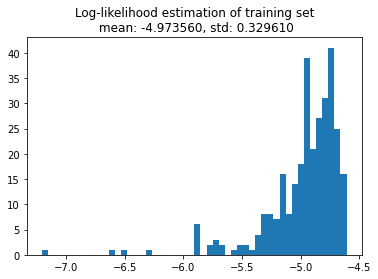

In [9]:
plt.hist(ll_train, bins=50)
plt.title('Log-likelihood estimation of training set\n mean: {:2f}, std: {:2f}'.format(ll_train.mean(), ll_train.std()))
plt.show()

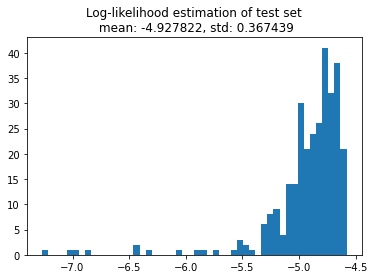

In [10]:
plt.hist(lls[0], bins=50)
plt.title('Log-likelihood estimation of test set\n mean: {:2f}, std: {:2f}'.format(lls[0].mean(), lls[0].std()))
plt.show()

In [11]:
fake_data = egan.generate(NoiseGenerator(306, sizes=cz, device=device)())
ll_fake = egan.surrogate_ll(fake_data, noise_gen).cpu().detach().numpy()

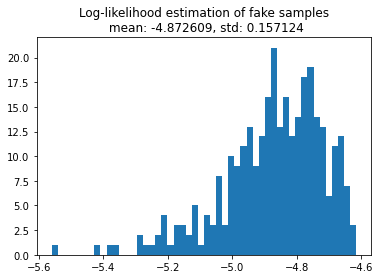

In [12]:
plt.hist(ll_fake, bins=50)
plt.title('Log-likelihood estimation of fake samples\n mean: {:2f}, std: {:2f}'.format(ll_fake.mean(), ll_fake.std()))
plt.show()

# Gaussian Noise
Inspect the surrogate log likelihood evaluation of samples polluted by Gaussain noises of different scales. The severer the noise the lower the log likelihood.

In [5]:
noise_level = torch.linspace(0, 0.5, 50)
lls = np.zeros([50, len(test_data)])
gnoise = torch.randn(*(test_data.shape), device=test_data.device)

for i, level in enumerate(noise_level):
    lls[i] = egan.surrogate_ll(test_data + level * gnoise, noise_gen).cpu().detach().numpy()

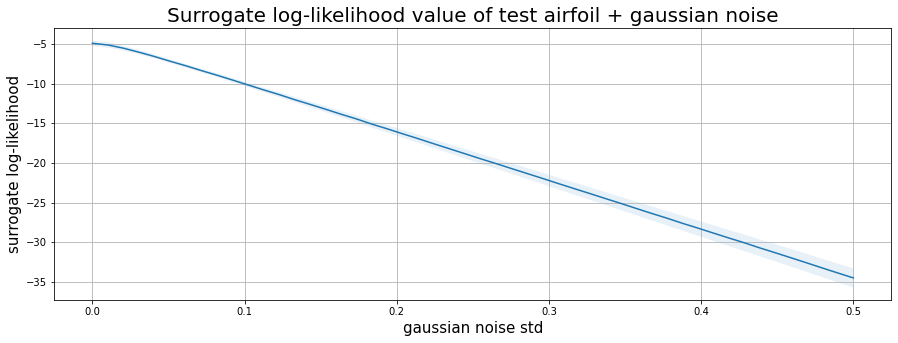

In [6]:
lls_mean = lls.mean(axis=1) 
lls_std = lls.std(axis=1) 

plt.figure(figsize=(15, 5))
plt.xlabel("gaussian noise std", fontsize=15) 
plt.ylabel("surrogate log-likelihood", fontsize=15)
plt.title('Surrogate log-likelihood value of test airfoil + gaussian noise', fontsize=20)
plt.grid()  
plt.fill_between(noise_level, lls_mean - lls_std,  
                    lls_mean + lls_std, alpha=0.1)  
plt.plot(noise_level, lls_mean, '-') 
plt.show()


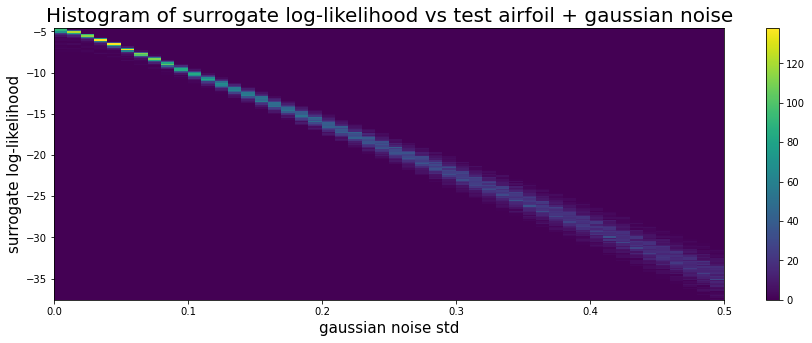

In [7]:
plt.figure(figsize=(15, 5))
plt.hist2d((np.ones_like(lls) * noise_level.view(-1, 1).numpy()).flatten(), lls.flatten(), bins=[50, 200])
plt.xlabel("gaussian noise std", fontsize=15) 
plt.ylabel("surrogate log-likelihood", fontsize=15)
plt.title('Histogram of surrogate log-likelihood vs test airfoil + gaussian noise', fontsize=20)
plt.colorbar()
plt.show()

# Scaling
Inspect the effect of scaling on log likelihood evaluation. 

In [46]:
scales = torch.linspace(0, 2, 51)
lls = np.zeros([len(scales), len(test_data)])

for i, scale in enumerate(scales):
    lls[i] = egan.surrogate_ll(test_data * scale, noise_gen).cpu().detach().numpy()

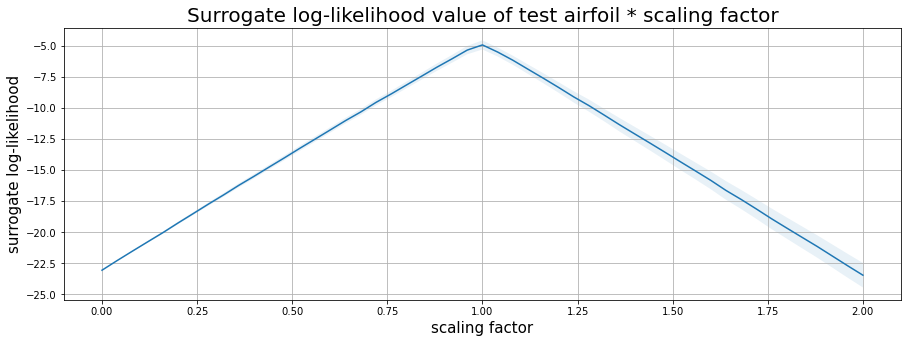

In [47]:
lls_mean = lls.mean(axis=1) 
lls_std = lls.std(axis=1) 

plt.figure(figsize=(15, 5))
plt.xlabel("scaling factor", fontsize=15) 
plt.ylabel("surrogate log-likelihood", fontsize=15)
plt.title('Surrogate log-likelihood value of test airfoil * scaling factor', fontsize=20)
plt.grid()  
plt.fill_between(scales, lls_mean - lls_std,  
                    lls_mean + lls_std, alpha=0.1)  
plt.plot(scales, lls_mean, '-') 
plt.show()

# Shifting

In [38]:
x_grid, y_grid = torch.meshgrid(torch.linspace(-0.5, 0.5, 11), torch.linspace(-0.5, 0.5, 11))
xs = x_grid.flatten(); ys = y_grid.flatten()
scores = torch.zeros(len(xs), len(test_data))
for i in range(len(xs)):
    scores[i] = egan.surrogate_ll(
        test_data + torch.tensor([xs[i], ys[i]], device=device).reshape(1, 2, 1), 
        noise_gen).cpu().detach()

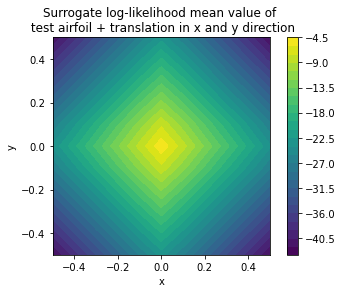

In [44]:
plt.contourf(x_grid, y_grid, scores.mean(dim=-1).reshape(11, 11), levels=30)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Surrogate log-likelihood mean value of \n test airfoil + translation in x and y direction')
plt.axes().set_aspect('equal')
plt.show()

# Rotation

In [61]:
def rotate(input, angle, center=torch.tensor([0.5, 0])):
    R = torch.tensor([
        [torch.cos(angle), -torch.sin(angle)], 
        [torch.sin(angle), torch.cos(angle)]
        ], device=input.device)
    x = input.transpose(1, 2) - center.to(input.device)
    return (x @ R.T + center.to(input.device)).transpose(1, 2)

In [62]:
from math import pi
angles = torch.linspace(0, 2 * pi, 30)
lls = np.zeros([len(angles), len(test_data)])

for i, angle in enumerate(angles):
    lls[i] = egan.surrogate_ll(rotate(test_data, angle), noise_gen).cpu().detach().numpy()

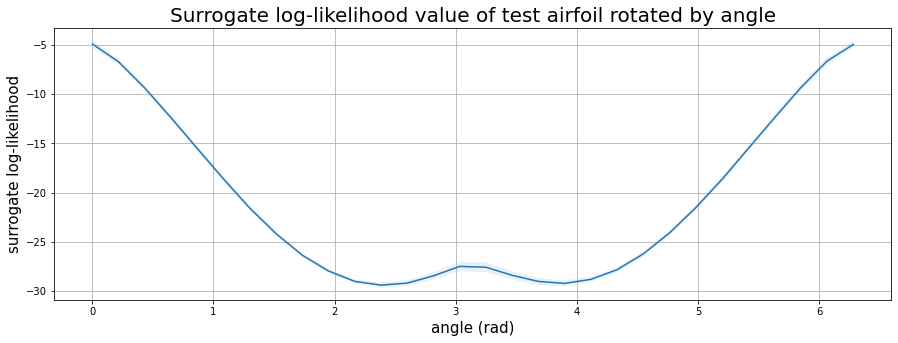

In [64]:
lls_mean = lls.mean(axis=1) 
lls_std = lls.std(axis=1) 

plt.figure(figsize=(15, 5))
plt.xlabel("angle (rad)", fontsize=15) 
plt.ylabel("surrogate log-likelihood", fontsize=15)
plt.title('Surrogate log-likelihood value of test airfoil rotated by angle', fontsize=20)
plt.grid()  
plt.fill_between(angles, lls_mean - lls_std,  
                    lls_mean + lls_std, alpha=0.1)  
plt.plot(angles, lls_mean, '-') 
plt.show()